In [1]:
import tensorflow as tf
import tensorflow.keras as K

In [2]:
def upscale_layer(layer, upscale_factor):
  '''
  upscale_factor 만큼 층(tensor)을 업스케일
  tensor 크기는 [group, height, weight, channels]
  '''
  height, width = layer.get_shape()[1:3]
  size = (upscale_factor * height, upscale_factor * width)
  upscaled_layer = tf.image.resize_nearest_neighbor(layer, size) #최근접 이웃 보간을 사용하여 resize
  return upscaled_layer

In [3]:
def smoothly_merge_last_layer(list_of_layers, alpha):
  '''
  임곗값 알파를 기반으로 층을 부드럽게 합침
  모든 층이 RGB로 바뀌었다고 가정
  생성자를 위한 함수
  list_of_layers : 해상도 순서대로 정렬된 텐서 리스트
  alpha : 0~1 사이의 실수
  '''

  last_fully_trained_layer = list_of_layers[-2]
  # 업스케일링을 위해 끝에서 두 번째 층 선택
  last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)
  # 마지막으로 훈련된 층을 업스케일링
  larger_native_layer = list_of_layers[-1]
  # 새로 추가된 층은 아직 완전히 훈련되지 않음

  assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()
  #합치기 전 층 크기가 같은지 확인
  new_layer = (1-alpha) * last_layer_upscaled + alpha * larger_native_layer
  # 곱셈은 브로드캐스팅되어 수행
  return new_layer

In [3]:
def minibatch_std_layer(layer, group_size = 4):
  '''
  층의 미니배치 표준편차를 계산
  층의 데이터 타입은 float32로 가정
  '''

  group_size = K.backend.minimum(group_size, tf.shape(layer)[0])
  # 미니배치는 group_size로 나눌 수 있거나 group_size 보다 작거나 같아야 함
  shape = list(K.int_shape(input))
  shape[0] = tf.shape(input)[0]
  #크기정보 따로 저장, 그래프 실행 전에는 일반적으로 배치차원이 None이기 때문에 tf.shape를 이용해서 크기를 얻음
  minibatch = K.backend.reshape(layer, (group_size, -1, shape[1], shape[2], shape[3]))
  #미니배치 수준에서 연산을 위해 reshape. [그룹, 미니배치, 너비, 높이, 채널]의 형태
  minibatch -= tf.reduce_mean(minibatch, axis = 0, keepdims = True)
  #[M, W, H, C] 그룹의 평균 계산
  minibatch = tf.reduce_mean(K.backend.square(minibatch), axis = 0)
  #[M, W, H, C] 그룹의 분산 계산
  minibatch = K.backend.sqrt(minibatch + 1e-8)
  #[M, W, H, C] 그룹의 표준편차 계산
  minibatch = tf.reduce_sum(minibatch, axis = [1, 2, 3], keepdims = True)
  # 특성맵을 평균하여 [M, 1, 1, 1]의 픽셀을 얻음
  minibatch = K.backend.title(minibatch, [group_size, 1, shape[2], shape[3]])
  #스칼라 값을 그룹과 픽셀에 맞게 변환
  return K.backend.concatenate([layer, minibatch], axis = 1) #새로운 특성맵 추가

In [4]:
def equalize_learning_rate(shape, gain, fan_in = None):
  '''
  He 초기화의 상수로 모든 층의 가중치를 조정하여 특성마다 각기 다른 다이내믹 레인지를 가지도록 분산을 맞춤
  shape : 텐서의 크기(각 층의 차원), [커널 크기, 커널 크기, 필터 개수, 특성 맵] -> 달라질 수 있음
  gain : 일반적으로 sqrt(2)
  fan_in : He 초기화에서 입력 연결 계수
  '''

  if fan_in is None:
    fan_in = np.prod(shape[:-1])
    #기본 값은 특성맵 차원을 제외하고 shape의 모든 차원을 곱함. -> 뉴런마다 입력 연결 계수를 얻음
  std = gain / K.sqrt(fan_in) #He 초기화 상수
  wscale = K.constant(std, name = 'wscale', dtype = np.float32) #조정을 위한 상수
  adjusted_weights = K.get_value('layer', shape = shape, initializer = tf.initializers.random_normal()) * wscale
  # 가중치 값을 얻어 브로드캐스팅으로 wscale값 적용
  return adjusted_weights

In [5]:
def pixelwise_feat_norm(inputs, **kwargs):
  '''
  크리젭스키와 연구진에 제안한 픽셀별 특성 정규화
  '''
  normalization_constant = K.backend.sqrt(K.backend.mean(inputs ** 2, axis = -1, keepdims = True) + 1.0e-8)
  return inputs / normalization_constant

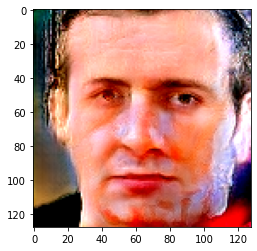

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

module = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')
latent_dim = 512

latent_vector = tf.random.normal([1, latent_dim], seed = 1337)

interpolated_images = module(latent_vector)

plt.imshow(interpolated_images.numpy().reshape(128, 128, 3))
plt.show()